In [11]:
import os
import tabula
import tabula
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

out_fld = 'M:/Lender Services/.output-files/'
gbq_prj = 'data-lake-prod-223818'
plt.style.use('seaborn-white')
pd.set_option('display.max_columns', 500)

In [2]:
sql_params = open('sql\loan_params.sql', 'r')
sql_params = sql_params.read()
sql_params = sql_params.format(input('LenderID? '))

sql_performance = open('sql\portfolio_performance.sql', 'r')
sql_performance = sql_performance.read()
sql_performance = sql_performance.format(sql_params)

sql_performance_agg = open('sql\portfolio_performance_agg.sql', 'r')
sql_performance_agg = sql_performance_agg.read()
sql_performance_agg = sql_performance_agg.format(sql_params)

sql_performance_all_vins = open('sql\portfolio_performance_agg_all_vins.sql', 'r')
sql_performance_all_vins = sql_performance_all_vins.read()
sql_performance_all_vins = sql_performance_all_vins.format(sql_params)

LenderID?  7221731


In [3]:
def annualize_value(value):
    annualized_value = (1 + value)**12 - 1
    return annualized_value

In [4]:
def calc_net_return(df):
    net_return = (1+ (pd.to_numeric(df['InterestPaid'])
       + pd.to_numeric(df['TotalFees'])
       + pd.to_numeric(df['RecoveryPrinPaid'])
       + pd.to_numeric(df['NetCashToInvestorsFromDebtSale'])
       - pd.to_numeric(df['CO_Balance']))
    / pd.to_numeric(df['LoanAmount']))**12 - 1
    return net_return

In [5]:
def calc_cumul_prepay(df):
    cpp = (df['FullPaydowns'] + df['VoluntaryExcessPrin']).cumsum() / df['LoanAmount']
    return pd.to_numeric(cpp)

In [6]:
def calc_cdr(df):
    smm = (df['CO_Balance'] / df['UPB'])
    cdr = 1 - (1 - smm)**12
    return pd.to_numeric(cdr)

In [8]:
def calc_cpr(df):
    smm = (df['FullPaydowns'] + df['VoluntaryExcessPrin']) / (df['UPB'] - df['ScheduledPeriodicPrin'])
    cpr = 1 - (1 - smm)**12
    return pd.to_numeric(cpr)

In [9]:
def get_performance_data(strat='inception to date'):
    if strat=='by rating and term':
        df = pd.read_gbq(sql_performance, project_id=gbq_prj, dialect='standard')
        df['OriginationQuarter'] = pd.to_datetime(df['OriginationQuarter'].str[-4:] + df['OriginationQuarter'].str[:2])
        df['OriginationQuarter'] = df['OriginationQuarter'].dt.to_period("Q")
        df['AnnualizedNetReturn'] = calc_net_return(df)
        df['CumulPrepay'] = calc_cumul_prepay(df)
        df['CPR'] = calc_cpr(df)
        df['CDR'] = calc_cdr(df)
        return df

    elif strat=='inception to date':
        df = pd.read_gbq(sql_performance_all_vins, project_id=gbq_prj, dialect='standard')
        df['AnnualizedNetReturn'] = calc_net_return(df)
        df['CumulPrepay'] = calc_cumul_prepay(df)
        df['CPR'] = calc_cpr(df)
        df['CDR'] = calc_cdr(df)
        return df
    
    else:
        df = pd.read_gbq(sql_performance_agg, project_id=gbq_prj, dialect='standard')
        df['OriginationQuarter'] = pd.to_datetime(df['OriginationQuarter'].str[-4:] + df['OriginationQuarter'].str[:2])
        df['OriginationQuarter'] = df['OriginationQuarter'].dt.to_period("Q")
        df['AnnualizedNetReturn'] = calc_net_return(df)
        df['CumulPrepay'] = calc_cumul_prepay(df)
        df['CPR'] = calc_cpr(df)
        df['CDR'] = calc_cdr(df)
        return df    

In [14]:
def plot_page1_charts(df):

    plt.style.use('seaborn-white')
    fig, axs = plt.subplots(2,2, figsize=(20, 10), sharey=False, sharex=True)
    plt.suptitle('PMIT Performance', fontsize=22)
    subplot_font=16
    xticks = df['ObsMonth'].unique()

    axs1_col = df['AnnualizedNetReturn']
    axs[0,0].set_ylabel('Percent')
    axs[0,0].grid()
    axs[0,0].set_title('Annualized Net Return', fontsize=subplot_font)
    axs[0,0].plot(
            df['ObsMonth']
            , axs1_col
                )

    axs2_col = df['DPD_31']
    axs[0,1].set_ylabel('Percent')
    axs[0,1].grid()
    axs[0,1].set_title('Percent Dollars DQ', fontsize=subplot_font)
    axs[0,1].plot(
            df['ObsMonth']
            , df['DPD_31']
            , label='DQ 30+'
                )
    axs[0,1].plot(
            df['ObsMonth']
            , df['DPD_61']
            , label='DQ 60+'
                )
    axs[0,1].plot(
            df['ObsMonth']
            , df['DPD_91']
            , label='DQ 90+'
                )
    axs[0,1].legend()

    axs3_col = df['CumulativeNetLossesPct']
    axs[1,0].set_ylabel('Percent')
    axs[1,0].grid()
    axs[1,0].set_title('Cumulative Net Loss Percent', fontsize=subplot_font)
    axs[1,0].plot(
            df['ObsMonth']
            , axs3_col
                )

    axs4_col = df['CumulPrepay']
    axs[1,1].set_ylabel('Percent')
    axs[1,1].grid()
    axs[1,1].set_title('Cumulative Prepay Percent', fontsize=subplot_font)
    axs[1,1].plot(
            df['ObsMonth']
            , axs4_col
                )
    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=45)
        ax.set_yticklabels(['{:,.2%}'.format(y) for y in ax.get_yticks()])

    plt.tight_layout(rect=[0.1, 0.1, 1, 0.95])
    return plt

In [23]:
def plot_page2_charts(df):

    plt.style.use('seaborn-white')
    fig, axs = plt.subplots(2,2, figsize=(20, 10), sharey=False, sharex=False)
    plt.suptitle('PMIT Performance', fontsize=22)
    subplot_font = 16
    xticks = df['ObsMonth'].unique()

    axs1_col = df['CDR']
    axs[0,0].set_ylabel('Percent')
    axs[0,0].grid()
    axs[0,0].set_title(axs1_col.name, fontsize=subplot_font)
    axs[0,0].set_yticklabels(['{:,.2%}'.format(y) for y in axs[0,0].get_yticks()])
    axs[0,0].plot(
            df['ObsMonth']
            , axs1_col
                )

    axs2_col = df['CPR']
    axs[0,1].set_ylabel('Percent')
    axs[0,1].grid()
    axs[0,1].set_title(axs2_col.name, fontsize=subplot_font)
    axs[0,1].set_yticklabels(['{:,.2%}'.format(y) for y in axs[0,0].get_yticks()])
    axs[0,1].plot(
            df['ObsMonth']
            , axs2_col
                )
    
    begin_upb = df['PrevUPB'].max()
    cur_upb = df['UPB'].min()
                 
    begin_upb = '${:0,.0f}'.format(begin_upb).replace('$-','-$')
    cur_upb = '${:0,.0f}'.format(cur_upb).replace('$-', '-$')
    
    table_data = [begin_upb, cur_upb]
    
    axs[1,0].table(cellText=[
        table_data
    ]
                   ,colWidths=[0.3] * 2
                   ,fontsize=22
                   ,rowLabels=['Principal Balance']
                   ,colLabels=['Closing','Current']
                   ,bbox=[0.2, 0.2, 0.6, 0.5]
                   ,loc='center'
                   
                  )
    
    axs[1,0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    axs[1,0].tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
    for pos in ['right','top','bottom','left']:
        axs[1,0].spines[pos].set_visible(False)
    
    axs[1,1] = plot_wt_factors()
       
    plt.tight_layout(rect=[0.1, 0.1, 1, 0.95])

    return plt

<module 'matplotlib.pyplot' from 'c:\\users\\bmauck\\appdata\\local\\programs\\python\\python36\\lib\\site-packages\\matplotlib-2.2.3-py3.6-win-amd64.egg\\matplotlib\\pyplot.py'>

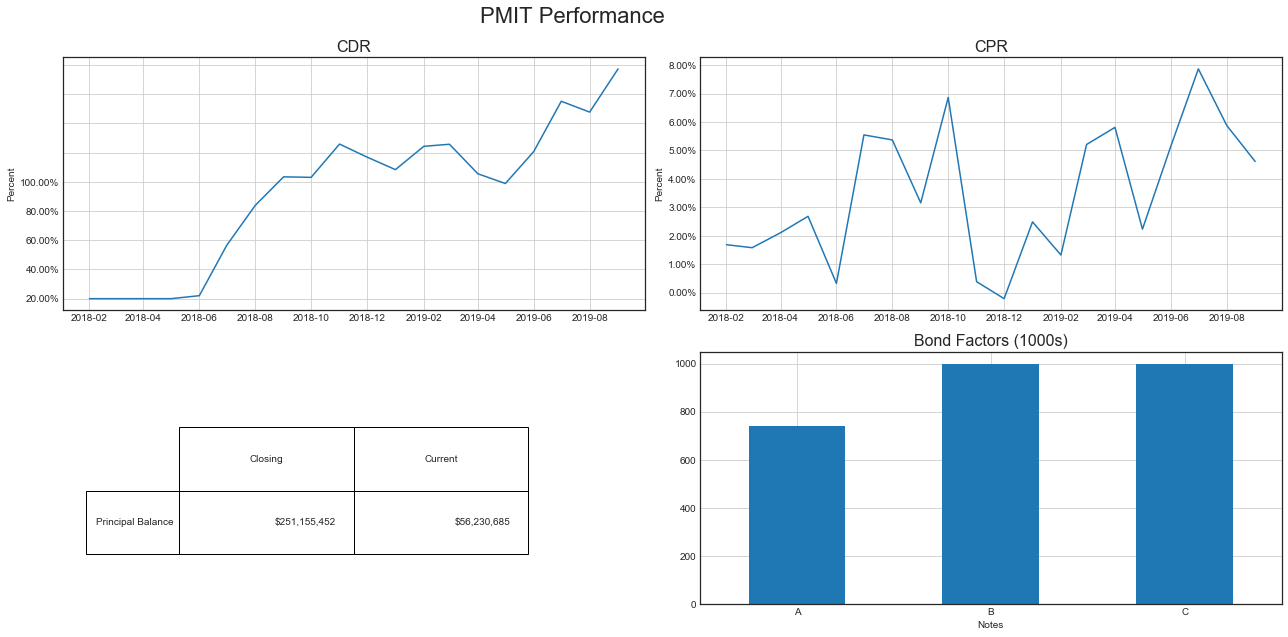

In [26]:
plot_page2_charts(df)

In [25]:
def plot_wt_factors():
    tables = tabula.read_pdf('PROSP19_2-DIS-2019-09.pdf', pages=3, multiple_tables=True)
    df = tables[0].T
    df = df.set_index(0, drop=True)
    df = df.T
    df = df.set_index('Notes', drop=True)   
    pd.to_numeric(df['Endingx Balancex']).plot(kind='bar')
    plt.title('Bond Factors (1000s)', fontsize=16)
    plt.grid()
    plt.xticks(rotation=0)
    return plt

In [12]:
def plot_all_charts(df=get_performance_data()):
    plot_page1_charts(df)
    plot_page2_charts(df)

In [20]:
df = get_performance_data()

FileNotFoundError: [Errno 2] No such file or directory: 'PROSP19_2-DIS-2019-09.pdf'

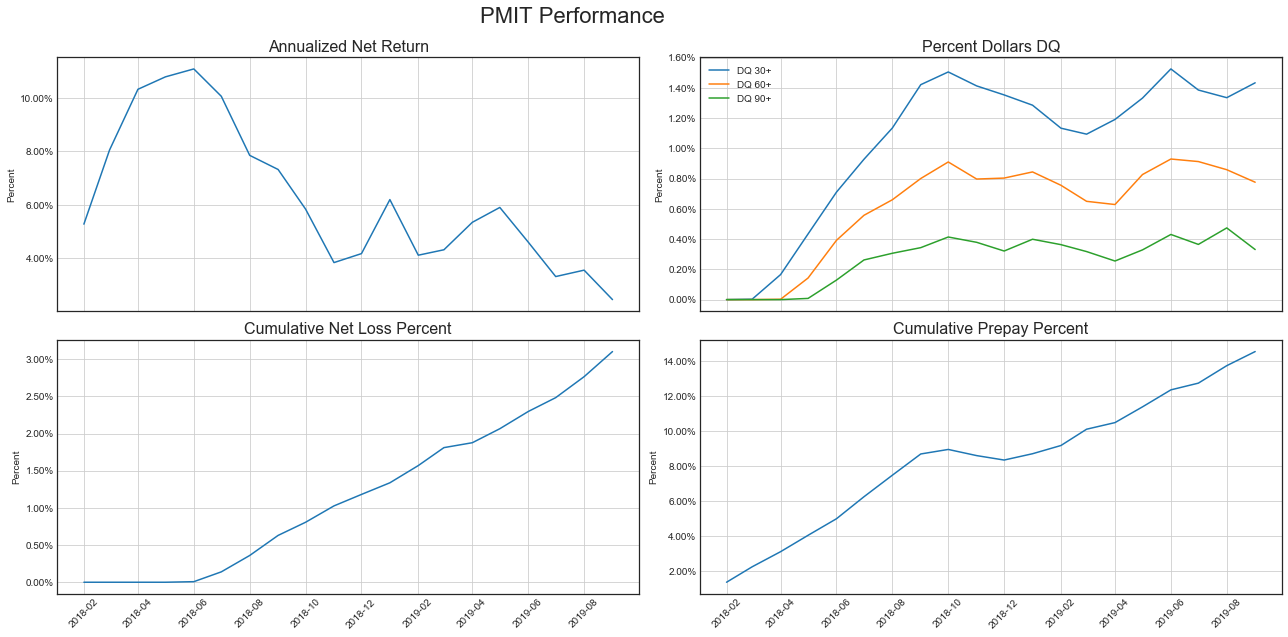

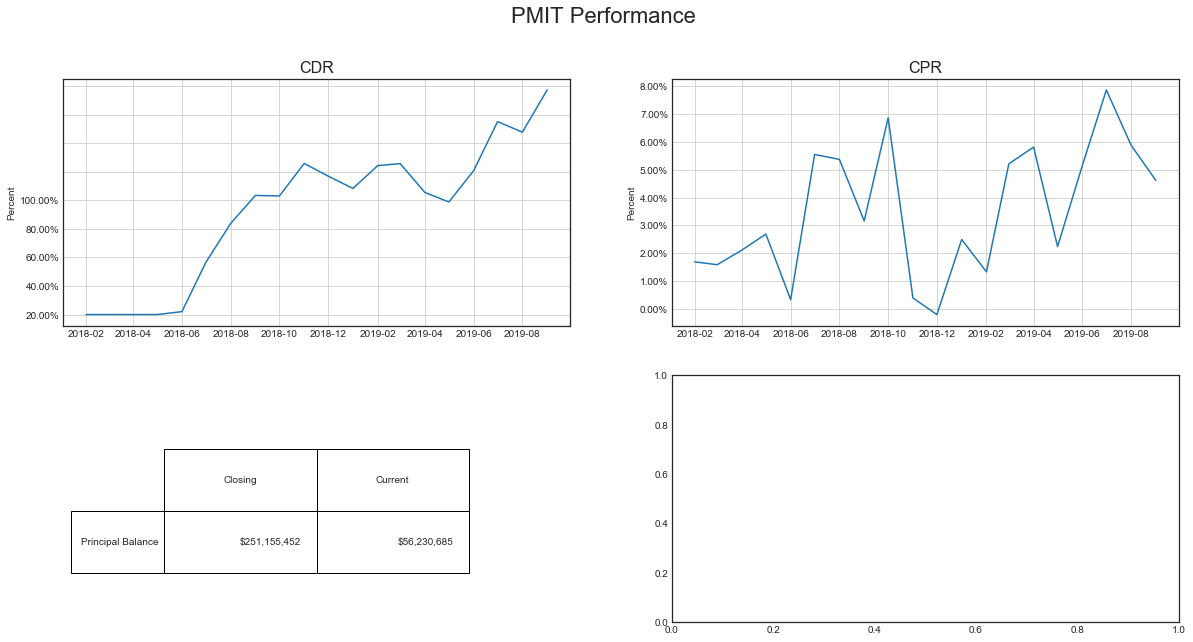

In [28]:
plot_all_charts()

In [51]:
out_file = 'historical-performance-meag.xlsx'
writer = pd.ExcelWriter(out_file, engine='xlsxwriter')

for i in range (0,5):
    df = pd.read_excel(in_file.format(str(i)))
    df['Net Return'] = calc_anr(df)
    df.to_excel(writer, sheet_name=str(i))

writer.save()

In [153]:
plt.style.use('seaborn')
fig, ax = plt.subplots()

ax.set_title('Net Annualized Return')
ax.set_xlabel('Month')
ax.set_ylabel('Return')


for qtr in sorted(df['OriginationQuarter'].unique()):
    plt.plot(
    pd.to_datetime(df['ObsMonth'])[df['OriginationQuarter'] == qtr]
    , df['DPD_31'][df['OriginationQuarter'] == qtr]
    , label=qtr
    )
plt.legend()
plt.show();